In [110]:
from sklearn import *
import pandas as pd
import numpy as np
import re
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
nltk.download("stopwords")
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charubaiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# pos \ neg - комменты с твиттера http://study.mokoron.com/ 
# labeled каггловский датасет по токсикам https://www.kaggle.com/blackmoon/russian-language-toxic-comments

In [3]:
twitter_neg = pd.read_csv('data/negative.csv',sep=';',header=None,usecols=[3])
twitter_pos = pd.read_csv('data/positive.csv',sep=';',header=None,usecols=[3])
vk_all = pd.read_csv('data/labeled.csv')

In [4]:
ttl_toxic = vk_all.append(twitter_neg.rename(columns={3:'comment'})).fillna(1)
df = ttl_toxic.append(twitter_pos.rename(columns={3:'comment'})).fillna(0)


In [5]:
df['toxic'].value_counts(normalize=True)

0.0    0.516058
1.0    0.483942
Name: toxic, dtype: float64

In [6]:
scores = {}

In [93]:
data,val_data,target,val_target = model_selection.train_test_split(vk_all['comment'],vk_all['toxic'],train_size=.75)

### stupid baseline

In [8]:
tf = feature_extraction.text.TfidfVectorizer(min_df=10)

In [9]:
tf.fit(data)

TfidfVectorizer(min_df=10)

In [10]:
clf_base = linear_model.LogisticRegression(max_iter=1000)
pipe_base = pipeline.make_pipeline(tf,clf_base)

In [11]:
scores['baseline'] = pd.DataFrame(model_selection.cross_validate(pipe_base,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

In [12]:
pipe_base.fit(data,target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=10)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [13]:
pd.DataFrame(scores)

,baseline
fit_time,0.242109
score_time,0.039719
test_f1,0.670582
test_precision,0.836171
test_recall,0.559889


### work with text

In [14]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
stopwords = nltk.corpus.stopwords.words('russian')

In [15]:
def normalizer (text):
    words_only = re.sub('[^А-я]+',' ',text.lower())
    doc = Doc(words_only)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    clean_text = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        if (token.lemma not in stopwords) & (len(set(token.lemma))>1):
            clean_text.append(token.lemma)
            
    return ' '.join(clean_text)

In [16]:
raw_data = data.copy()

In [94]:
old_text = ' жожо '.join(data)

In [95]:
new_text = normalizer(old_text)

In [96]:
data = new_text.split('жожо')

In [20]:
clf_norm = linear_model.LogisticRegression(max_iter=1000)
pipe_norm = pipeline.make_pipeline(tf,clf_norm)
scores['normalize'] = pd.DataFrame(model_selection.cross_validate(pipe_norm,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

In [21]:
pipe_norm.fit(data,target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=10)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [22]:
pd.DataFrame(scores)

,baseline,normalize
fit_time,0.242109,0.168174
score_time,0.039719,0.025518
test_f1,0.670582,0.704610
test_precision,0.836171,0.877150
test_recall,0.559889,0.588935


### micro EDA

In [23]:
eda = vk_all.copy(deep=True)

In [24]:
eda['txt_len'] = eda['comment'].str.len()
eda['txt_len_avg'] = eda['comment'].str.split().apply(lambda x: np.mean([len(word) for word in x]))
eda['txt_words'] = eda['comment'].str.count(' ')
eda['txt_puncts'] = eda['comment'].str.count('[^\w^ ]')
eda['txt_upper_cnt'] = eda['comment'].apply(lambda x: len([i for i in x if i.isupper()]))
eda['txt_pct_upper'] = eda['txt_upper_cnt'] / eda['txt_len']
eda['txt_pos_punc'] = eda['comment'].apply(lambda text: len(re.findall(r'\)|D',text)))
eda['txt_neg_punc'] = eda['comment'].apply(lambda text: len(re.findall(r'\(|C|c|С|c',text)))

In [25]:
eda.groupby('toxic')[eda.filter(regex='txt').columns].agg(['mean','std'])

txt_len             txt_len_avg            txt_words             \
             mean         std        mean       std       mean        std   
toxic                                                                       
0.0    194.213332  274.750067    5.312308  1.063207  29.713436  40.811415   
1.0    141.392665  261.776417    5.467866  1.466984  21.449233  42.106635   

      txt_puncts           txt_upper_cnt            txt_pct_upper            \
            mean       std          mean        std          mean       std   
toxic                                                                         
0.0     7.481849  9.135183      3.984978   7.812980      0.023631  0.027502   
1.0     5.972234  9.188326      6.595939  26.932055      0.052774  0.130923   

      txt_pos_punc           txt_neg_punc            
              mean       std         mean       std  
toxic                                                
0.0       0.279261  0.709825     0.499478  1.353467  
1.0       0.094488  0.434023     0.454414  1.689128

In [26]:
eda.iloc[:,1:].corr()

,toxic,txt_len,txt_len_avg,txt_words,txt_puncts,txt_upper_cnt,txt_pct_upper,txt_pos_punc,txt_neg_punc
toxic,1.000000,-0.091782,0.060394,-0.094138,-0.077608,0.072997,0.171514,-0.136895,-0.014424
txt_len,-0.091782,1.000000,0.024703,0.991756,0.924170,0.370052,-0.047513,0.382291,0.529863
txt_len_avg,0.060394,0.024703,1.000000,-0.025150,0.016616,0.022158,0.079450,-0.001665,0.037176
txt_words,-0.094138,0.991756,-0.025150,1.000000,0.929034,0.368631,-0.049015,0.378389,0.514993
txt_puncts,-0.077608,0.924170,0.016616,0.929034,1.000000,0.346096,-0.033393,0.418016,0.497885
txt_upper_cnt,0.072997,0.370052,0.022158,0.368631,0.346096,1.000000,0.565105,0.115176,0.692265
txt_pct_upper,0.171514,-0.047513,0.079450,-0.049015,-0.033393,0.565105,1.000000,-0.040094,0.312005
txt_pos_punc,-0.136895,0.382291,-0.001665,0.378389,0.418016,0.115176,-0.040094,1.000000,0.395420
txt_neg_punc,-0.014424,0.529863,0.037176,0.514993,0.497885,0.692265,0.312005,0.395420,1.000000


### features

In [27]:
def features_from_text(df):
    df = pd.DataFrame(df)
    df.columns=['text']
    df['txt_len'] = df['text'].str.len()
    df['txt_len_avg'] = df['text'].str.split().apply(lambda x: np.mean([len(word) for word in x]))
    df['txt_words'] = df['text'].str.count(' ')
    df['txt_puncts'] = df['text'].str.count('[^\w^ ]')
    df['txt_upper_cnt'] = df['text'].apply(lambda x: len([i for i in x if i.isupper()]))
    df['txt_pos_punc'] = df['text'].apply(lambda text: len(re.findall(r'\)|D',text)))
    df['txt_neg_punc'] = df['text'].apply(lambda text: len(re.findall(r'\(|C|c|С|c',text)))
    
    return df.drop('text',axis=1).fillna(0)

In [28]:
fe_tf = feature_extraction.text.TfidfVectorizer(min_df=10)
fe_tf.fit(data,target)
new_fe=preprocessing.FunctionTransformer(features_from_text)
text_preproc = pipeline.FeatureUnion([('idf',fe_tf),('fe',new_fe)])

In [29]:
clf_fe = linear_model.LogisticRegression(max_iter=1000)
pipe_fe = pipeline.Pipeline([('preproc',text_preproc),('clf',clf_fe)])

In [30]:
scores['features'] = pd.DataFrame(model_selection.cross_validate(pipe_fe,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._

In [31]:
pipe_fe.fit(data,target)

/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Pipeline(steps=[('preproc',
                 FeatureUnion(transformer_list=[('idf',
                                                 TfidfVectorizer(min_df=10)),
                                                ('fe',
                                                 FunctionTransformer(func=<function features_from_text at 0x7f92b818fe50>))])),
                ('clf', LogisticRegression(max_iter=1000))])

In [32]:
pd.DataFrame(scores)

,baseline,normalize,features
fit_time,0.242109,0.168174,0.618072
score_time,0.039719,0.025518,0.076721
test_f1,0.670582,0.704610,0.708455
test_precision,0.836171,0.877150,0.875075
test_recall,0.559889,0.588935,0.595297


### vectors

In [33]:
from navec import Navec

In [34]:
nav = Navec.load('emb_navec.tar')

In [35]:
def get_sentence_vecror(sentence_list):
    vectors = []
    for sentence in sentence_list:
        sent_vec = []
        for i in sentence.split():
            if i in nav:
                sent_vec.append(nav[i])
            else:
                sent_vec.append(nav['<unk>'])
        if sentence.strip() == '':
            sent_vec = [nav['<unk>']]
        vectors.append(np.mean(sent_vec,axis=0))
    return np.vstack(vectors)

In [36]:
vec_func = preprocessing.FunctionTransformer(get_sentence_vecror)

In [37]:
clf_vec = linear_model.LogisticRegression(max_iter=1000)
pipe_vec = pipeline.make_pipeline(vec_func,clf_vec)

In [38]:
scores['sample_vec'] = pd.DataFrame(model_selection.cross_validate(pipe_vec,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

In [39]:
pipe_vec.fit(data,target)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function get_sentence_vecror at 0x7f92b5df8af0>)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [40]:
pd.DataFrame(scores)

,baseline,normalize,features,sample_vec
fit_time,0.242109,0.168174,0.618072,1.262928
score_time,0.039719,0.025518,0.076721,0.278110
test_f1,0.670582,0.704610,0.708455,0.800196
test_precision,0.836171,0.877150,0.875075,0.832169
test_recall,0.559889,0.588935,0.595297,0.770678


### combo

In [41]:
word_vectorizer = feature_extraction.text.TfidfVectorizer(min_df=10)
word_vectorizer.fit(data)

TfidfVectorizer(min_df=10)

In [42]:
char_vectorizer = feature_extraction.text.TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char',
    ngram_range=(2,5))
char_vectorizer.fit(data)

TfidfVectorizer(analyzer='char', ngram_range=(2, 5), sublinear_tf=True)

In [43]:
idf_fu = pipeline.FeatureUnion([('idf_w',word_vectorizer),('idf_c',char_vectorizer)])

In [44]:
clf_2idf = linear_model.LogisticRegression(max_iter=1000)
pipe_idf_fe = pipeline.Pipeline([('idf',idf_fu),('clf',clf_2idf)])

In [45]:
scores['idf_features'] = pd.DataFrame(model_selection.cross_validate(pipe_idf_fe,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

In [46]:
pipe_idf_fe.fit(data,target)

Pipeline(steps=[('idf',
                 FeatureUnion(transformer_list=[('idf_w',
                                                 TfidfVectorizer(min_df=10)),
                                                ('idf_c',
                                                 TfidfVectorizer(analyzer='char',
                                                                 ngram_range=(2,
                                                                              5),
                                                                 sublinear_tf=True))])),
                ('clf', LogisticRegression(max_iter=1000))])

In [47]:
pd.DataFrame(scores)

,baseline,normalize,features,sample_vec,idf_features
fit_time,0.242109,0.168174,0.618072,1.262928,6.238955
score_time,0.039719,0.025518,0.076721,0.278110,0.583107
test_f1,0.670582,0.704610,0.708455,0.800196,0.792038
test_precision,0.836171,0.877150,0.875075,0.832169,0.897874
test_recall,0.559889,0.588935,0.595297,0.770678,0.708714


### blend models

In [48]:
vec_func = preprocessing.FunctionTransformer(get_sentence_vecror)

In [98]:
clf_lr_vec = linear_model.LogisticRegression(max_iter=1000,C=6,penalty='l1',solver='liblinear')
clf_nb_vec = naive_bayes.BernoulliNB()
clf_knn_vec = neighbors.KNeighborsClassifier(30)
clf_svc_vec = svm.SVC()
clf_mlp_vec = neural_network.MLPClassifier(max_iter=500)
clf_rf_vec = ensemble.RandomForestClassifier()

In [149]:
plot_metrics = {}
for i in tqdm(np.arange(10,120,10)):
    tmp_data = vec_func.transform(data)
    clf = ensemble.RandomForestClassifier(max_depth =i,n_estimators=1000).fit(tmp_data,target)
    tmp_val_data = vec_func.transform(val_data)
    plot_metrics[i]=metrics.f1_score(val_target,clf.predict(tmp_val_data))

  0%|          | 0/11 [01:15<?, ?it/s]


KeyboardInterrupt: 

<AxesSubplot:>

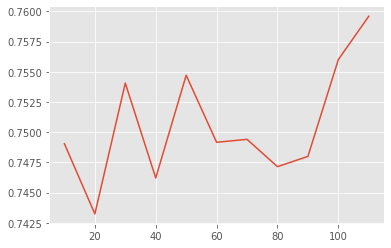

In [ ]:
pd.Series(plot_metrics).plot()

In [85]:
models = {}
for n,model in tqdm(enumerate([clf_lr_vec,clf_nb_vec,clf_knn_vec,clf_svc_vec,clf_rf_vec,clf_mlp_vec])):
    tmp_pipe = pipeline.make_pipeline(vec_func,model)
    models[n] = pd.DataFrame(model_selection.cross_validate(tmp_pipe,data,target,scoring=['f1','precision','recall'],cv=5)).mean()
    print(models[n])

1it [00:07,  7.42s/it]

fit_time          1.212226
score_time        0.270333
test_f1           0.800196
test_precision    0.832169
test_recall       0.770678
dtype: float64


2it [00:14,  7.03s/it]

fit_time          1.067528
score_time        0.284028
test_f1           0.709332
test_precision    0.709422
test_recall       0.709544
dtype: float64


3it [00:22,  7.62s/it]

fit_time          1.039625
score_time        0.621425
test_f1           0.738581
test_precision    0.706601
test_recall       0.774274
dtype: float64


4it [01:02, 20.45s/it]

fit_time          6.360856
score_time        1.660540
test_f1           0.813744
test_precision    0.847526
test_recall       0.782573
dtype: float64


5it [01:50, 30.37s/it]

fit_time          9.275806
score_time        0.313407
test_f1           0.740342
test_precision    0.841739
test_recall       0.660858
dtype: float64


/home/charubaiel/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charubaiel/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charubaiel/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charubaiel/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
6it [02:43, 27.17s/it]

fit_time          10.194652
score_time         0.293193
test_f1            0.795268
test_precision     0.796256
test_recall        0.794744
dtype: float64


In [49]:
clf_lr_vec = linear_model.LogisticRegression(max_iter=1000)
clf_nb_vec = naive_bayes.BernoulliNB()
clf_f_vec = ensemble.RandomForestClassifier(n_estimators=300,max_depth=3)
vote_vec = ensemble.VotingClassifier(estimators=[('lr',clf_lr_vec),('nb',clf_nb_vec),('rf',clf_f_vec)],voting='soft')

In [50]:
pipe_vote_vec = pipeline.make_pipeline(vec_func,vote_vec)

In [51]:
scores['vote_models'] = pd.DataFrame(model_selection.cross_validate(pipe_vote_vec,data,target,scoring=['f1','precision','recall'],cv=5)).mean()

In [52]:
pipe_vote_vec.fit(data,target)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function get_sentence_vecror at 0x7f92b5df8af0>)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000)),
                                              ('nb', BernoulliNB()),
                                              ('rf',
                                               RandomForestClassifier(max_depth=3,
                                                                      n_estimators=300))],
                                  voting='soft'))])

In [53]:
pd.DataFrame(scores)

,baseline,normalize,features,sample_vec,idf_features,vote_models
fit_time,0.242109,0.168174,0.618072,1.262928,6.238955,8.454006
score_time,0.039719,0.025518,0.076721,0.278110,0.583107,0.327737
test_f1,0.670582,0.704610,0.708455,0.800196,0.792038,0.733347
test_precision,0.836171,0.877150,0.875075,0.832169,0.897874,0.765736
test_recall,0.559889,0.588935,0.595297,0.770678,0.708714,0.704011


### blend results

In [54]:
def voting(estimators,x,func=np.mean):
    probs = []
    for i in estimators:
        probs.append(i.predict_proba(x)[:,1])
    return np.apply_over_axes(func,np.array(probs),axes=0)[0]

In [97]:
raw_val_data = val_data.copy()
val_data = pd.Series(normalizer(' жожо '.join(val_data)).split('жожо'))

In [56]:
eval_data = defaultdict(list)
for model in [pipe_norm,pipe_fe,pipe_idf_fe,pipe_vec,pipe_vote_vec]:
    eval_data['f1'].append(metrics.f1_score(val_target,model.predict(val_data)))
    eval_data['recall'].append(metrics.recall_score(val_target,model.predict(val_data)))
    eval_data['precision'].append(metrics.precision_score(val_target,model.predict(val_data)))

/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/charubaiel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [57]:
eval_data['f1'].append(metrics.f1_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data).round()))
eval_data['recall'].append(metrics.recall_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data).round()))
eval_data['precision'].append(metrics.precision_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data).round()))

In [58]:
eval_data['f1'].append(metrics.f1_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data,func=np.max).round()))
eval_data['recall'].append(metrics.recall_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data,func=np.max).round()))
eval_data['precision'].append(metrics.precision_score(val_target,voting([pipe_vec,pipe_idf_fe],val_data,func=np.max).round()))

In [67]:
pd.DataFrame(eval_data,index=['norm','fe','idf_df','vec','vote_vec','blend_mean','blend_max']).sort_values(by='f1',ascending=False)

,f1,recall,precision
blend_max,0.843621,0.846408,0.840853
blend_mean,0.818870,0.759703,0.888031
idf_df,0.805929,0.718415,0.917722
vec,0.800348,0.759703,0.845588
fe,0.731827,0.615194,0.903030
norm,0.731731,0.616020,0.900966
vote_vec,0.715929,0.668043,0.771211


### final